# Notebook per Predicció de Matèria Seca (MS) en Patates

Aquest notebook entrena una xarxa neuronal per predir el percentatge de 
matèria seca a partir de les característiques de color i NIR de les patates.

Columnes del dataset:
- id_mostra: identificador únic
- ruta_imatges: ruta a la imatge
- color_promig_R, color_promig_G, color_promig_B: colors mitjans RGB
- desviació_R, desviació_G, desviació_B: desviacions estàndard dels canals
- canal_NIR: valor del canal infraroig proper
- MS_experimental: percentatge de matèria seca (TARGET)
- lot: identificador del lot
- data: data de captura


## 1. IMPORTACIÓ DE LLIBRERIES


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuració per reproducibilitat
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")




TensorFlow version: 2.13.0
GPU disponible: []


## 2. CÀRREGA I EXPLORACIÓ DE DADES


Directori d'output: data/output/test_run1

=== INFORMACIÓ DEL DATASET ===
Nombre de mostres: 10

Columnes disponibles:
['id_mostra', 'ruta_imatges', 'color_promig_R', 'color_promig_G', 'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR', 'MS_experimental', 'lot', 'data']

Primeres files:
   id_mostra          ruta_imatges  color_promig_R  color_promig_G  \
0          1  data/images/L1_1.png           158.3           132.7   
1          2  data/images/L1_2.png           162.9           136.4   
2          3  data/images/L1_3.png           149.6           128.3   
3          4  data/images/L2_4.png           171.2           142.5   
4          5  data/images/L2_5.png           167.8           140.1   

   color_promig_B  desviació_R  desviació_G  desviació_B  canal_NIR  \
0            96.4         12.5         10.2          8.7      0.742   
1           101.2         11.8          9.6          7.9      0.755   
2            93.1         13.1         11.0          9

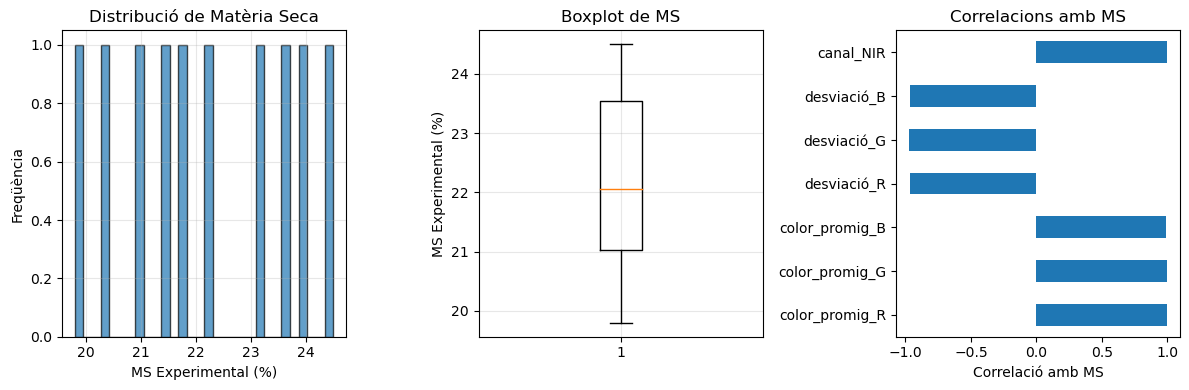

In [13]:
# Definir rutes
os.chdir("D:/potato-dry-matter-optics-ml")
RUTA_DATASET = "data/input/training/training_set.csv"
RUTA_OUTPUT = "data/output/test_run1"

# Crear directori d'output si no existeix
os.makedirs(RUTA_OUTPUT, exist_ok=True)
print(f"Directori d'output: {RUTA_OUTPUT}")

# Carregar les dades
df = pd.read_csv(RUTA_DATASET)

print("\n=== INFORMACIÓ DEL DATASET ===")
print(f"Nombre de mostres: {len(df)}")
print(f"\nColumnes disponibles:\n{df.columns.tolist()}")
print(f"\nPrimeres files:")
print(df.head())

# Estadístiques descriptives
print("\n=== ESTADÍSTIQUES DESCRIPTIVES ===")
print(df.describe())

# Comprovar valors nuls
print("\n=== VALORS NULS ===")
print(df.isnull().sum())

# Visualització de la distribució de MS
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['MS_experimental'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('MS Experimental (%)')
plt.ylabel('Freqüència')
plt.title('Distribució de Matèria Seca')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(df['MS_experimental'])
plt.ylabel('MS Experimental (%)')
plt.title('Boxplot de MS')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Correlació entre features i MS
features_cols = ['color_promig_R', 'color_promig_G', 'color_promig_B', 
                 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR']
correlations = df[features_cols + ['MS_experimental']].corr()['MS_experimental'].drop('MS_experimental')
correlations.plot(kind='barh')
plt.xlabel('Correlació amb MS')
plt.title('Correlacions amb MS')
plt.tight_layout()
plt.show()




## 3. PREPARACIÓ DE LES DADES


In [14]:

# Seleccionar les columnes d'entrada (features) i sortida (target)
feature_cols = ['color_promig_R', 'color_promig_G', 'color_promig_B',
                'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR']
target_col = 'MS_experimental'

# Extreure X (inputs) i y (target)
X = df[feature_cols].values
y = df[target_col].values

print("\n=== PREPARACIÓ DE DADES ===")
print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")

# Separar en conjunt d'entrenament (80%) i validació (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nConjunt d'entrenament: {X_train.shape[0]} mostres")
print(f"Conjunt de validació: {X_val.shape[0]} mostres")

# Normalització (StandardScaler)
# És important normalitzar per ajudar a la xarxa neuronal a convergir millor
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

print("\n=== NORMALITZACIÓ COMPLETADA ===")
print(f"Mitjana X_train: {X_train_scaled.mean(axis=0)}")
print(f"Desviació estàndard X_train: {X_train_scaled.std(axis=0)}")





=== PREPARACIÓ DE DADES ===
Shape de X (features): (10, 7)
Shape de y (target): (10,)

Conjunt d'entrenament: 8 mostres
Conjunt de validació: 2 mostres

=== NORMALITZACIÓ COMPLETADA ===
Mitjana X_train: [-2.19269047e-15  1.30451205e-15 -1.77635684e-15 -1.16573418e-15
  5.55111512e-16  4.71844785e-16  3.38618023e-15]
Desviació estàndard X_train: [1. 1. 1. 1. 1. 1. 1.]


## 4. DEFINICIÓ DEL MODEL


In [15]:
# Funció MAPE personalitzada per Keras
def mape_metric(y_true, y_pred):
    diff = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, 1e10))
    return 100. * tf.reduce_mean(diff)

def crear_model(n_features, arquitectura=[64, 32, 16], 
                learning_rate=0.001, dropout_rate=0.2):
    """
    Crea una xarxa neuronal densa per regressió amb arquitectura flexible.
    
    Paràmetres:
    -----------
    n_features : int
        Nombre de features d'entrada
    arquitectura : list
        Llista amb el nombre de neurones per cada capa oculta
        Exemple: [64, 128, 20, 10] crea 4 capes amb 64, 128, 20 i 10 neurones
    learning_rate : float
        Taxa d'aprenentatge per Adam
    dropout_rate : float
        Taxa de dropout per regularització (s'aplica després de cada capa)
    
    Retorna:
    --------
    model : keras.Model
        Model compilat
    """
    model = keras.Sequential()
    
    # Capa d'entrada
    model.add(layers.Input(shape=(n_features,)))
    
    # Afegir capes ocultes segons l'arquitectura especificada
    for i, n_neurons in enumerate(arquitectura):
        model.add(layers.Dense(n_neurons, activation='relu', 
                              name=f'hidden_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    # Capa de sortida (regressió, 1 neurona sense activació)
    model.add(layers.Dense(1, name='output'))
    
    # Compilar el model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error per regressió
        metrics=[mape_metric]  # MAPE com a mètrica
    )
    
    return model

# NOTA: No creem el model aquí perquè ho farem després del GridSearch
n_features = X_train_scaled.shape[1]
print(f"\n=== NOMBRE DE FEATURES: {n_features} ===")





=== NOMBRE DE FEATURES: 7 ===


## 5. GRIDSEARCH PER TROBAR LA MILLOR CONFIGURACIÓ


In [16]:

import json
from datetime import datetime
from IPython.display import clear_output

# Crear directori per guardar checkpoints dins de RUTA_OUTPUT
checkpoints_dir = os.path.join(RUTA_OUTPUT, 'checkpoints')
os.makedirs(checkpoints_dir, exist_ok=True)

def gridsearch_amb_checkpoints(X_train, y_train, X_val, y_val, configuracions, 
                                epochs_display=20):
    """
    Cerca manual de la millor configuració d'hiperparàmetres amb checkpoints.
    
    Paràmetres:
    -----------
    configuracions : list of dict
        Llista de diccionaris amb diferents configuracions a provar
        Cada config ha de tenir: 'arquitectura', 'learning_rate', 'dropout_rate', 'epochs'
    epochs_display : int
        Mostrar informació cada N èpoques (per defecte: 20)
    
    Retorna:
    --------
    millor_config : dict
        Millor configuració trobada
    resultats : list
        Resultats de totes les configuracions
    """
    resultats = []
    
    print("\n" + "="*70)
    print("INICI DEL GRIDSEARCH")
    print("="*70)
    
    for i, config in enumerate(configuracions):
        print(f"\n{'='*70}")
        print(f"CONFIGURACIÓ {i+1}/{len(configuracions)}")
        print(f"{'='*70}")
        print(f"Arquitectura: {config['arquitectura']}")
        print(f"Learning rate: {config['learning_rate']}")
        print(f"Dropout rate: {config['dropout_rate']}")
        print(f"Batch size: {config.get('batch_size', 16)}")
        print(f"Epochs: {config.get('epochs', 200)}")
        
        # Crear nom únic per aquesta configuració
        config_name = f"config_{i+1}_arch_{'_'.join(map(str, config['arquitectura']))}"
        checkpoint_path = os.path.join(checkpoints_dir, f"{config_name}.h5")
        
        # Crear i entrenar model
        model_temp = crear_model(
            n_features, 
            arquitectura=config['arquitectura'],
            learning_rate=config['learning_rate'],
            dropout_rate=config['dropout_rate']
        )
        
        # Callback personalitzat per mostrar progress cada N èpoques
        class DisplayCallback(keras.callbacks.Callback):
            def __init__(self, display_freq=20):
                self.display_freq = display_freq
                
            def on_epoch_end(self, epoch, logs=None):
                if (epoch + 1) % self.display_freq == 0:
                    print(f"Època {epoch+1}/{self.params['epochs']}: "
                          f"loss={logs['loss']:.4f}, MAPE={logs['mape_metric']:.2f}%, "
                          f"val_loss={logs['val_loss']:.4f}, val_MAPE={logs['val_mape_metric']:.2f}%")
        
        # Callbacks per aquest entrenament
        callbacks_temp = [
            EarlyStopping(
                monitor='val_loss', 
                patience=20, 
                restore_best_weights=True, 
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=0
            ),
            keras.callbacks.ModelCheckpoint(
                checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=0
            ),
            DisplayCallback(display_freq=epochs_display)
        ]
        
        # Entrenar
        print(f"\nEntrenant...")
        history_temp = model_temp.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config.get('epochs', 200),
            batch_size=config.get('batch_size', 16),
            callbacks=callbacks_temp,
            verbose=0
        )
        
        # Carregar el millor model guardat
        model_temp = keras.models.load_model(checkpoint_path, custom_objects={'mape_metric': mape_metric})
        
        # Avaluar amb el conjunt de validació
        y_pred_temp = model_temp.predict(X_val, verbose=0).flatten()
        
        # Desnormalitzar per calcular mètriques reals
        y_pred_real = scaler_y.inverse_transform(y_pred_temp.reshape(-1, 1)).flatten()
        y_val_real = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
        
        # Calcular mètriques
        mape_temp = mean_absolute_percentage_error(y_val_real, y_pred_real)
        rmse_temp = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
        mae_temp = np.mean(np.abs(y_val_real - y_pred_real))
        r2_temp = r2_score(y_val_real, y_pred_real)
        
        # Guardar resultats
        resultat = {
            'config_id': i + 1,
            'config': config,
            'checkpoint_path': checkpoint_path,
            'mape': mape_temp,
            'rmse': rmse_temp,
            'mae': mae_temp,
            'r2': r2_temp,
            'val_loss_final': min(history_temp.history['val_loss']),
            'epochs_entrenats': len(history_temp.history['loss'])
        }
        resultats.append(resultat)
        
        print(f"\n{'─'*70}")
        print(f"RESULTATS CONFIG {i+1}:")
        print(f"  MAPE: {mape_temp*100:.2f}%")
        print(f"  RMSE: {rmse_temp:.3f}")
        print(f"  MAE: {mae_temp:.3f}")
        print(f"  R²: {r2_temp:.3f}")
        print(f"  Èpoques entrenades: {len(history_temp.history['loss'])}")
        print(f"{'─'*70}")
    
    # Trobar la millor configuració (menor MAPE)
    millor = min(resultats, key=lambda x: x['mape'])
    
    print(f"\n{'='*70}")
    print("MILLOR CONFIGURACIÓ TROBADA")
    print(f"{'='*70}")
    print(f"Config ID: {millor['config_id']}")
    print(f"Arquitectura: {millor['config']['arquitectura']}")
    print(f"Learning rate: {millor['config']['learning_rate']}")
    print(f"Dropout rate: {millor['config']['dropout_rate']}")
    print(f"\nMÈTRIQUES:")
    print(f"  MAPE: {millor['mape']*100:.2f}%")
    print(f"  RMSE: {millor['rmse']:.3f}")
    print(f"  MAE: {millor['mae']:.3f}")
    print(f"  R²: {millor['r2']:.3f}")
    print(f"\nCheckpoint: {millor['checkpoint_path']}")
    print(f"{'='*70}\n")
    
    # Guardar tots els resultats en un JSON
    resultats_path = os.path.join(checkpoints_dir, 'resultats_gridsearch.json')
    with open(resultats_path, 'w') as f:
        # Convertir a format serialitzable
        resultats_serialitzable = []
        for r in resultats:
            r_copy = r.copy()
            for key in ['mape', 'rmse', 'mae', 'r2', 'val_loss_final']:
                r_copy[key] = float(r_copy[key])
            resultats_serialitzable.append(r_copy)
        
        json.dump({
            'data_execucio': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'millor_config_id': millor['config_id'],
            'resultats': resultats_serialitzable
        }, f, indent=2)
    
    print(f"✓ Resultats guardats a '{resultats_path}'\n")
    
    return millor, resultats


# Definir les configuracions a provar
configuracions = [
    # Configuracions simples (poques capes, poques neurones)
    {
        'arquitectura': [32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'batch_size': 3,
        'epochs': 200
    },
    {
        'arquitectura': [64, 32],
        'learning_rate': 0.001,
        'dropout_rate': 0.2,
        'batch_size': 3,
        'epochs': 200
    },
    
    # Configuracions mitjanes
    {
        'arquitectura': [64, 32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.2,
        'batch_size': 3,
        'epochs': 200
    },
    {
        'arquitectura': [128, 64, 32],
        'learning_rate': 0.0005,
        'dropout_rate': 0.2,
        'batch_size': 3,
        'epochs': 200
    },
    
    # Configuracions més complexes
    {
        'arquitectura': [128, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.3,
        'batch_size': 3,
        'epochs': 200
    },
    {
        'arquitectura': [64, 128, 64, 32],
        'learning_rate': 0.0005,
        'dropout_rate': 0.25,
        'batch_size': 3,
        'epochs': 200
    },
    
    # Provar amb learning rates diferents
    {
        'arquitectura': [64, 32, 16],
        'learning_rate': 0.01,
        'dropout_rate': 0.2,
        'batch_size': 3,
        'epochs': 200
    },
    {
        'arquitectura': [64, 32, 16],
        'learning_rate': 0.0001,
        'dropout_rate': 0.2,
        'batch_size': 3,
        'epochs': 200
    },
    
    # Provar amb dropouts diferents
    {
        'arquitectura': [64, 32, 16],
        'learning_rate': 0.001,
        'dropout_rate': 0.4,
        'batch_size': 3,
        'epochs': 200
    },
    
    # Provar arquitectures més profundes
    {
        'arquitectura': [128, 128, 64, 32, 16],
        'learning_rate': 0.0005,
        'dropout_rate': 0.3,
        'batch_size': 3,
        'epochs': 200
    },
]

print(f"\nS'executarà GridSearch amb {len(configuracions)} configuracions diferents")
print(f"Mostrant informació cada 20 èpoques\n")

# EXECUTAR GRIDSEARCH
millor_config, tots_resultats = gridsearch_amb_checkpoints(
    X_train_scaled, y_train_scaled, 
    X_val_scaled, y_val_scaled,
    configuracions,
    epochs_display=20
)





S'executarà GridSearch amb 10 configuracions diferents
Mostrant informació cada 20 èpoques


INICI DEL GRIDSEARCH

CONFIGURACIÓ 1/10
Arquitectura: [32, 16]
Learning rate: 0.001
Dropout rate: 0.1
Batch size: 3
Epochs: 200

Entrenant...
Època 20/200: loss=0.0521, MAPE=67.29%, val_loss=0.0128, val_MAPE=15.55%

──────────────────────────────────────────────────────────────────────
RESULTATS CONFIG 1:
  MAPE: 0.39%
  RMSE: 0.101
  MAE: 0.089
  R²: 0.992
  Èpoques entrenades: 32
──────────────────────────────────────────────────────────────────────

CONFIGURACIÓ 2/10
Arquitectura: [64, 32]
Learning rate: 0.001
Dropout rate: 0.2
Batch size: 3
Epochs: 200

Entrenant...
Època 20/200: loss=0.0737, MAPE=50.70%, val_loss=0.0279, val_MAPE=38.32%

──────────────────────────────────────────────────────────────────────
RESULTATS CONFIG 2:
  MAPE: 0.53%
  RMSE: 0.164
  MAE: 0.118
  R²: 0.978
  Èpoques entrenades: 35
──────────────────────────────────────────────────────────────────────

CONFIGURACIÓ 3

## 7. CARREGAR I AVALUAR EL MILLOR MODEL


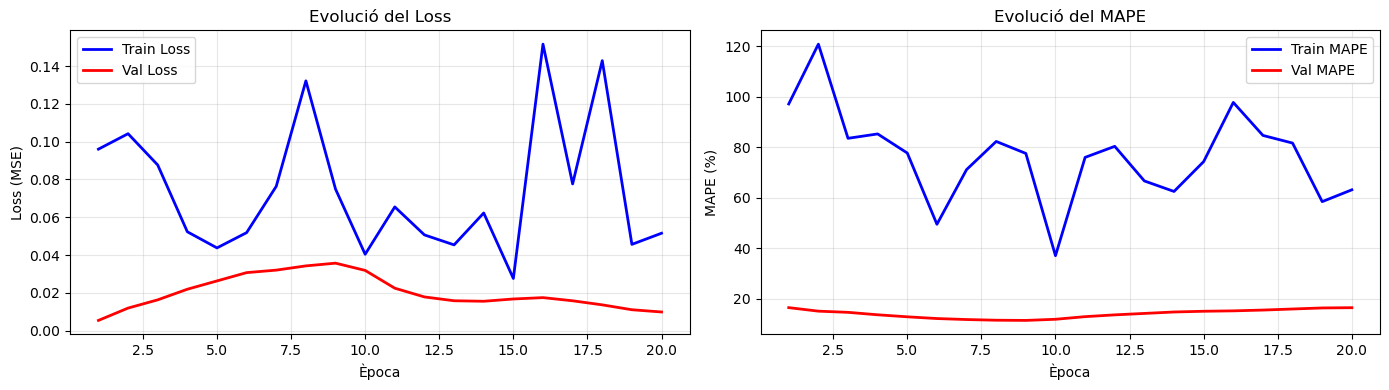

Època 20/200 - loss: 0.0516 - MAPE: 63.18% - val_loss: 0.0099 - val_MAPE: 16.45% - lr: 0.0005

=== ENTRENAMENT COMPLETAT ===


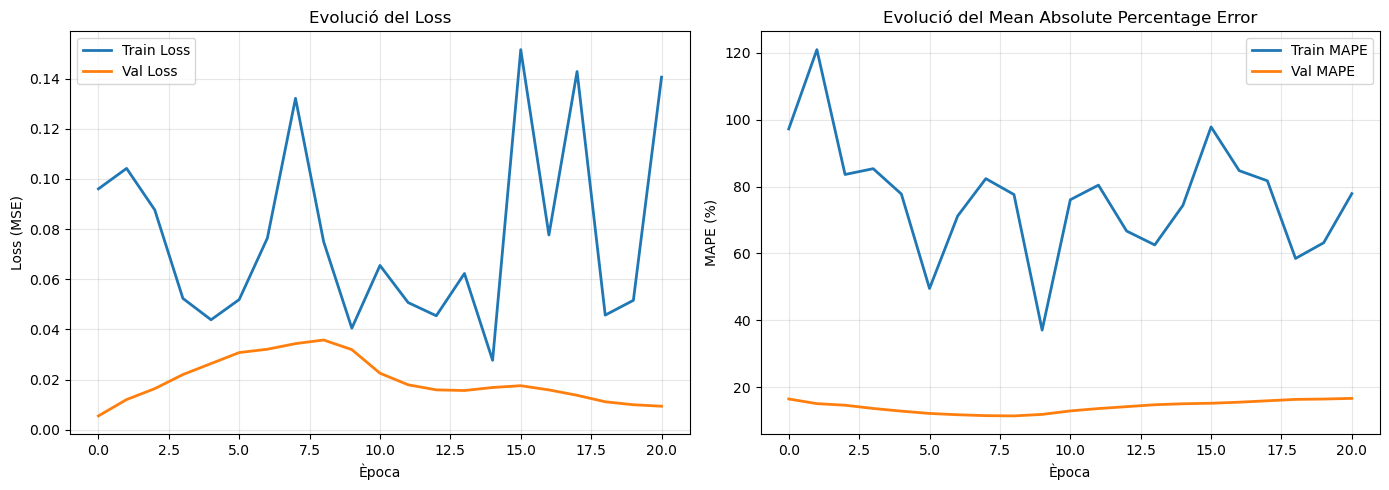

In [17]:

print("\n=== CARREGANT EL MILLOR MODEL ===")
print(f"Checkpoint: {millor_config['checkpoint_path']}")

# Carregar el millor model
millor_model = keras.models.load_model(millor_config['checkpoint_path'], custom_objects={'mape_metric': mape_metric})

print("\n=== ARQUITECTURA DEL MILLOR MODEL ===")
millor_model.summary()

# Re-entrenar breument per obtenir l'historial amb visualització animada
print("\n=== ENTRENAMENT FINAL AMB LA MILLOR CONFIGURACIÓ ===")
print("(Això és només per visualització i afinament final)\n")

# Callback personalitzat per animació
class AnimatedTrainingCallback(keras.callbacks.Callback):
    def __init__(self, display_freq=10, total_epochs=200):
        self.display_freq = display_freq
        self.total_epochs = total_epochs
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_mape_history = []
        self.val_mape_history = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Guardar històric
        self.train_loss_history.append(logs['loss'])
        self.val_loss_history.append(logs['val_loss'])
        self.train_mape_history.append(logs['mape_metric'])
        self.val_mape_history.append(logs['val_mape_metric'])
        
        if (epoch + 1) % self.display_freq == 0:
            # Esborrar output anterior
            clear_output(wait=True)
            
            # Crear gràfics
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
            
            epochs_range = range(1, len(self.train_loss_history) + 1)
            
            # Loss
            ax1.plot(epochs_range, self.train_loss_history, 'b-', label='Train Loss', linewidth=2)
            ax1.plot(epochs_range, self.val_loss_history, 'r-', label='Val Loss', linewidth=2)
            ax1.set_xlabel('Època')
            ax1.set_ylabel('Loss (MSE)')
            ax1.set_title('Evolució del Loss')
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # MAPE
            ax2.plot(epochs_range, self.train_mape_history, 'b-', label='Train MAPE', linewidth=2)
            ax2.plot(epochs_range, self.val_mape_history, 'r-', label='Val MAPE', linewidth=2)
            ax2.set_xlabel('Època')
            ax2.set_ylabel('MAPE (%)')
            ax2.set_title('Evolució del MAPE')
            ax2.legend()
            ax2.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Mostrar informació de l'època
            lr = self.model.optimizer.learning_rate
            if hasattr(lr, 'numpy'):
                lr_value = lr.numpy()
            else:
                lr_value = lr
            
            print(f"Època {epoch+1}/{self.total_epochs} - "
                  f"loss: {logs['loss']:.4f} - MAPE: {logs['mape_metric']:.2f}% - "
                  f"val_loss: {logs['val_loss']:.4f} - val_MAPE: {logs['val_mape_metric']:.2f}% - "
                  f"lr: {lr_value:.4f}")

callbacks_final = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=0
    ),
    AnimatedTrainingCallback(display_freq=10, total_epochs=200)
]

history = millor_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=millor_config['config'].get('batch_size', 16),
    callbacks=callbacks_final,
    verbose=0
)

print("\n=== ENTRENAMENT COMPLETAT ===")

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Època')
plt.ylabel('Loss (MSE)')
plt.title('Evolució del Loss')
plt.legend()
plt.grid(alpha=0.3)

# MAPE
plt.subplot(1, 2, 2)
plt.plot(history.history['mape_metric'], label='Train MAPE', linewidth=2)
plt.plot(history.history['val_mape_metric'], label='Val MAPE', linewidth=2)
plt.xlabel('Època')
plt.ylabel('MAPE (%)')
plt.title('Evolució del Mean Absolute Percentage Error')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. VISUALITZACIÓ DEL PROCÉS D'ENTRENAMENT


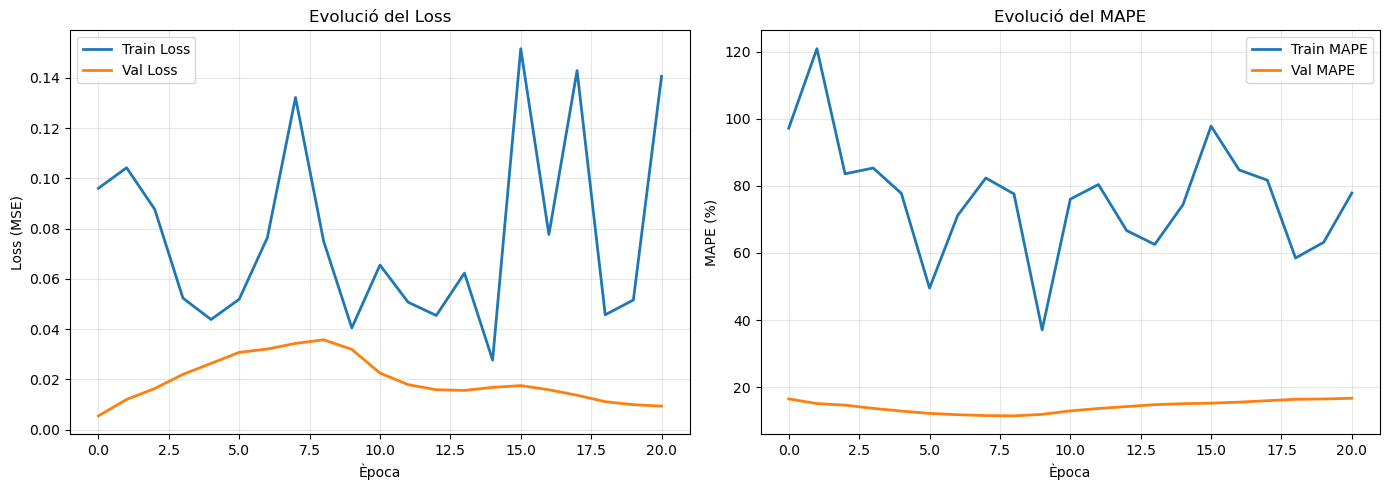

In [18]:

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Època')
plt.ylabel('Loss (MSE)')
plt.title('Evolució del Loss')
plt.legend()
plt.grid(alpha=0.3)

# MAPE
plt.subplot(1, 2, 2)
plt.plot(history.history['mape_metric'], label='Train MAPE', linewidth=2)
plt.plot(history.history['val_mape_metric'], label='Val MAPE', linewidth=2)
plt.xlabel('Època')
plt.ylabel('MAPE (%)')
plt.title('Evolució del MAPE')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()




## 9. AVALUACIÓ FINAL DEL MILLOR MODEL


In [19]:

# Prediccions en el conjunt de validació (normalitzat)
y_val_pred_scaled = millor_model.predict(X_val_scaled, verbose=0).flatten()

# Desnormalitzar les prediccions per obtenir valors reals
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()

# Calcular mètriques
mape = mean_absolute_percentage_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = np.mean(np.abs(y_val - y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("\n" + "="*70)
print("RESULTATS FINALS EN EL CONJUNT DE VALIDACIÓ")
print("="*70)
print(f"MAPE (Mean Absolute Percentage Error): {mape*100:.2f}%")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"MAE (Mean Absolute Error): {mae:.3f}")
print(f"R² (Coeficient de determinació): {r2:.3f}")
print("="*70)

# Interpretació dels resultats
print("\n=== INTERPRETACIÓ ===")
if mape < 0.15:
    print("✓ Excel·lent! MAPE < 15% - El model és molt precís")
elif mape < 0.20:
    print("✓ Acceptable. MAPE entre 15-20% - El model és força bo")
else:
    print("✗ Millorable. MAPE > 20% - Caldria més dades o millor preprocessament")





RESULTATS FINALS EN EL CONJUNT DE VALIDACIÓ
MAPE (Mean Absolute Percentage Error): 0.46%
RMSE (Root Mean Squared Error): 0.109
MAE (Mean Absolute Error): 0.107
R² (Coeficient de determinació): 0.990

=== INTERPRETACIÓ ===
✓ Excel·lent! MAPE < 15% - El model és molt precís


## 10. VISUALITZACIÓ DE PREDICCIONS


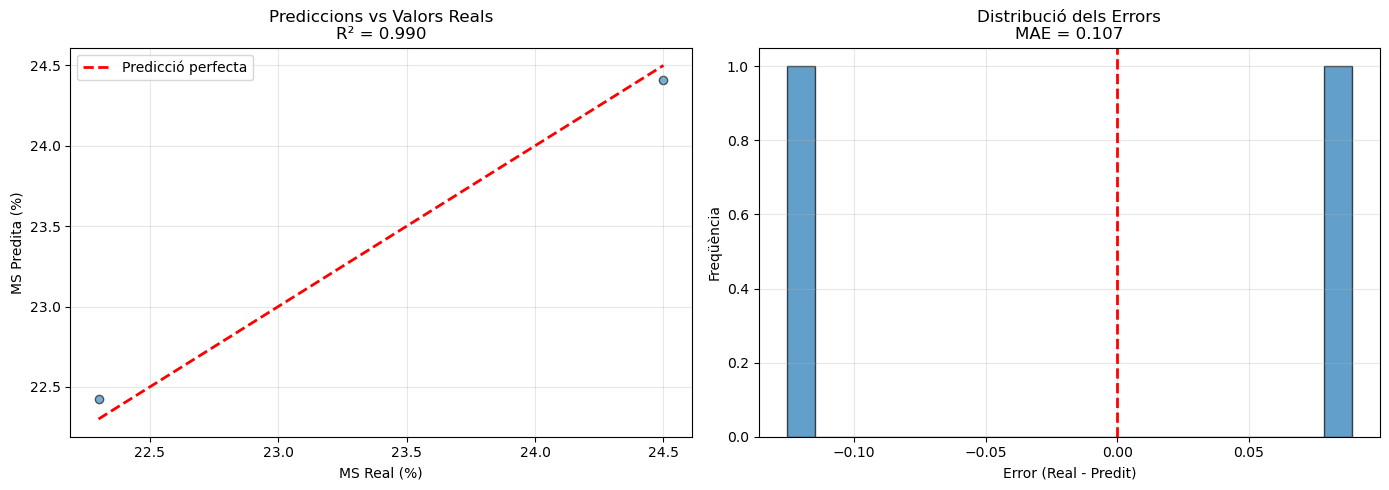

In [20]:

plt.figure(figsize=(14, 5))

# Gràfic de dispersió: valor real vs predit
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.6, edgecolor='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', linewidth=2, label='Predicció perfecta')
plt.xlabel('MS Real (%)')
plt.ylabel('MS Predita (%)')
plt.title(f'Prediccions vs Valors Reals\nR² = {r2:.3f}')
plt.legend()
plt.grid(alpha=0.3)

# Distribució dels errors
plt.subplot(1, 2, 2)
errors = y_val - y_val_pred
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Error (Real - Predit)')
plt.ylabel('Freqüència')
plt.title(f'Distribució dels Errors\nMAE = {mae:.3f}')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()




## 11. FUNCIÓ PER PREDIR NOVES MOSTRES


In [21]:

def predir_ms(nova_mostra, scaler_X, scaler_y, model):
    """
    Prediu el % de MS per una nova mostra.
    
    Paràmetres:
    -----------
    nova_mostra : dict o array
        Si és dict, ha de tenir les claus: 'color_promig_R', 'color_promig_G', 
        'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR'
        Si és array, ha de tenir els valors en aquest ordre
    
    Retorna:
    --------
    ms_predita : float
        Percentatge de matèria seca predit
    """
    # Convertir a array si és diccionari
    if isinstance(nova_mostra, dict):
        X_nova = np.array([[
            nova_mostra['color_promig_R'],
            nova_mostra['color_promig_G'],
            nova_mostra['color_promig_B'],
            nova_mostra['desviació_R'],
            nova_mostra['desviació_G'],
            nova_mostra['desviació_B'],
            nova_mostra['canal_NIR']
        ]])
    else:
        X_nova = np.array(nova_mostra).reshape(1, -1)
    
    # Normalitzar
    X_nova_scaled = scaler_X.transform(X_nova)
    
    # Predir
    y_pred_scaled = model.predict(X_nova_scaled, verbose=0)
    
    # Desnormalitzar
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()[0]
    
    return y_pred


# Exemple d'ús
print("\n=== EXEMPLE DE PREDICCIÓ ===")
mostra_exemple = {
    'color_promig_R': 150.0,
    'color_promig_G': 140.0,
    'color_promig_B': 120.0,
    'desviació_R': 20.0,
    'desviació_G': 18.0,
    'desviació_B': 15.0,
    'canal_NIR': 0.65
}

ms_predita = predir_ms(mostra_exemple, scaler_X, scaler_y, millor_model)
print(f"Mostra: {mostra_exemple}")
print(f"MS predita: {ms_predita:.2f}%")





=== EXEMPLE DE PREDICCIÓ ===
Mostra: {'color_promig_R': 150.0, 'color_promig_G': 140.0, 'color_promig_B': 120.0, 'desviació_R': 20.0, 'desviació_G': 18.0, 'desviació_B': 15.0, 'canal_NIR': 0.65}
MS predita: 16.74%


## 12. GUARDAR EL MILLOR MODEL I SCALERS


In [22]:

# Guardar el millor model amb un nom descriptiu (format .h5 per compatibilitat)
nom_model_final = f"model_prediccio_ms_final_MAPE_{mape*100:.2f}.h5"
ruta_model_final = os.path.join(RUTA_OUTPUT, nom_model_final)
millor_model.save(ruta_model_final)
print(f"\n✓ Millor model guardat com '{ruta_model_final}'")

# També guardar una còpia com a model per defecte
ruta_model_defecte = os.path.join(RUTA_OUTPUT, 'model_prediccio_ms.h5')
millor_model.save(ruta_model_defecte)
print(f"✓ Còpia guardada com '{ruta_model_defecte}'")

# Guardar els scalers amb pickle
ruta_scaler_X = os.path.join(RUTA_OUTPUT, 'scaler_X.pkl')
ruta_scaler_y = os.path.join(RUTA_OUTPUT, 'scaler_y.pkl')

import pickle
with open(ruta_scaler_X, 'wb') as f:
    pickle.dump(scaler_X, f)
with open(ruta_scaler_y, 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"✓ Scalers guardats com '{ruta_scaler_X}' i '{ruta_scaler_y}'")

# Guardar informació del millor model
info_model = {
    'arquitectura': millor_config['config']['arquitectura'],
    'learning_rate': millor_config['config']['learning_rate'],
    'dropout_rate': millor_config['config']['dropout_rate'],
    'batch_size': millor_config['config'].get('batch_size', 16),
    'epochs': millor_config['config'].get('epochs', 200),
    'mape': float(mape),
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2),
    'n_mostres_train': X_train.shape[0],
    'n_mostres_val': X_val.shape[0],
    'data_entrenament': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

ruta_info = os.path.join(RUTA_OUTPUT, 'info_millor_model.json')
with open(ruta_info, 'w') as f:
    json.dump(info_model, f, indent=2)
print(f"✓ Informació del model guardada a '{ruta_info}'")

print("\n" + "="*70)
print("PROCÉS COMPLETAT")
print("="*70)
print(f"\nDirectori d'output: {RUTA_OUTPUT}")
print("\nArxius generats:")
print(f"  - {nom_model_final}")
print(f"  - model_prediccio_ms.h5")
print(f"  - scaler_X.pkl")
print(f"  - scaler_y.pkl")
print(f"  - info_millor_model.json")
print(f"  - checkpoints/ (directori amb tots els checkpoints en format .h5)")
print(f"  - checkpoints/resultats_gridsearch.json")
print("\nPer carregar el model en el futur:")
print(f"  model = keras.models.load_model('{ruta_model_defecte}')")
print(f"  with open('{ruta_scaler_X}', 'rb') as f: scaler_X = pickle.load(f)")
print(f"  with open('{ruta_scaler_y}', 'rb') as f: scaler_y = pickle.load(f)")
print("="*70)



✓ Millor model guardat com 'data/output/test_run1\model_prediccio_ms_final_MAPE_0.46.h5'
✓ Còpia guardada com 'data/output/test_run1\model_prediccio_ms.h5'
✓ Scalers guardats com 'data/output/test_run1\scaler_X.pkl' i 'data/output/test_run1\scaler_y.pkl'
✓ Informació del model guardada a 'data/output/test_run1\info_millor_model.json'

PROCÉS COMPLETAT

Directori d'output: data/output/test_run1

Arxius generats:
  - model_prediccio_ms_final_MAPE_0.46.h5
  - model_prediccio_ms.h5
  - scaler_X.pkl
  - scaler_y.pkl
  - info_millor_model.json
  - checkpoints/ (directori amb tots els checkpoints en format .h5)
  - checkpoints/resultats_gridsearch.json

Per carregar el model en el futur:
  model = keras.models.load_model('data/output/test_run1\model_prediccio_ms.h5')
  with open('data/output/test_run1\scaler_X.pkl', 'rb') as f: scaler_X = pickle.load(f)
  with open('data/output/test_run1\scaler_y.pkl', 'rb') as f: scaler_y = pickle.load(f)
